
## mini-eSEES
# 2D ELASTIC FRAME STATIC ANALYSIS 
##                 using OpenSeesPy
####   by Silvia Mazzoni, 2021, silviamazzoni@yahoo.com


In [1746]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 100000;

<IPython.core.display.Javascript object>

In [1747]:
# Initialize Python
import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import widgets, Output
import math
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [1748]:
# Initialize Analysis Program
%run OpenSeesAnalysisFrameMainSilviaMazzoni.ipynb
InitializeAll()
showMeUnits()

Length: inch,ft,km,meter,dm,cm,mm
Force: kip,lbf,Newton,kNewton,kN
Time: sec,msec
Constants: g
Composite Length: inch2,inch3,inch4,ft2,ft3,ft4
Force&Length: ksf,psf,klf,plf
 Mass: kipmass(=lbf/g),lbm(=lbf/g)


In [1749]:
# OPTIONAL UNITE
#    Length: 'inch','ft','km','m','meter','dm','cm','mm'
#    Force: 'kip','lbf','N','Newton','kN','kgf'
#    Time: 'sec','s','msec','ms'
setMyUnits('inch','kip','sec'); # Length,Force,'Time'

g: 386.40000000000003
--OUTPUT UNITS--
Length Unit: inch
Force Unit: kip
Time Unit: sec


In [1750]:
# SECTION PROPERTIES
SectionLibrary = {}
SectionLibrary['Column1'] = {'SectionType': 'Elastic', 'A': 1e9*inch2,'E':29000*ksi,'Iz':1/12*24*24**3*inch4}
SectionLibrary['Column2'] = {'SectionType': 'Elastic', 'A': 1e9*inch2,'E':29000*ksi,'Iz':1/12*18*18**3*inch4}
SectionLibrary['Beam1'] = {'SectionType': 'Elastic', 'A': 1e9*inch2,'E':29000*ksi,'Iz':1/12*18*18**3*inch4}
SectionLibrary['Beam2'] = {'SectionType': 'Elastic', 'A': 1e9*inch2,'E':29000*ksi,'Iz':1/12*18*18**3*inch4}
SectionLibrary['Diagonal1'] = {'SectionType': 'Elastic', 'A': 16*16*inch2,'E':29000*ksi,'Iz':1/12*16*16**3*inch4}
SectionLibrary['Brace1'] = {'SectionType': 'Elastic', 'A': 6*6*inch2,'E':29000*ksi,'Iz':1e-6*inch4}

In [1751]:
## MODEL GEOMETRY
# total number of Bays
NbayTot = 4
# total number of Stories
NstoryTot = 2

# BayWidths = [Bay1Width1,Bay2Width,....,BayNbayWidth]
# StoryHeights = [Story1Height,Story2Height,....,StoryNstoryHeight]
BayWidths = [18*ft,14*ft,10*ft,10*ft]
StoryHeights = [20*ft,14*ft]

# Bays range from 1-Nbay
# Stories range from 1-Nstory
# ColumnLines range from 0-Nbay
# Floors range from 0-Nstory

In [1752]:
## BOUNDARY CONDITIONS
# The Default boundary conditions assign fixity to the base nodes and free dofs for all other nodes

#NodeFixity[Floor,ColumnLine,'dX,dY,dZ'] = 1 for fixed (default for Floor=1), 0 for released (default for Floor>0)
NodeFixity[1,2,'dY'] = 1 # by Floor, by ColumnLine
NodeFixity[0,4,'rZ'] = 0

In [1753]:
## COLUMNS
# You need to define a whole row of column sections for each story.
# Number of entries per story = Number of Column Lines (=Number of Bays + 1)
# Story count starts at 1 and ends at Nstory
# Assign 0 to entries where there is no element

#ColumnSectionStoryArray[Story] = [Column1SectionLabel,Column2SectionLabel,....,ColumnNstorySectionLabel] 
ColumnSectionStoryArray[1] = [0,'Column1','Column1','Column1','Column1'] # by Story, by ColumnLine
ColumnSectionStoryArray[2] = [0,'Column2','Column2',0,'Column1']


In [1754]:
## BEAMS
# You need to define a whole row of beam sections for each floor. 
# Number of entries per floor = Number of Bays
# Floor count starts at 0 (=ground) and ends at Nstory
# Assign 0 to entries where there is no element

#BeamSectionFloorArray[Floor] = [Bay1SectionLabel,Bay2SectionLabel,....,BayNbaySectionLabel]
BeamSectionFloorArray[0] = [0,0,0,0,0,0]  # don't really have to specify an empty floor
BeamSectionFloorArray[1] = [0,'Beam1','Beam1','Beam1','Beam1','Beam1'] # by Floor, by Bay
BeamSectionFloorArray[2] = [0,'Beam2','Beam2','Beam1','Beam1','Beam1']


In [1755]:
## BEAM RELEASES for Simply-Supported Beams
# You need to define a whole row of beam sections for each floor. 
# Not all floors need to be defined, but all bays within a floor must be defined
# Number of entries per floor = Number of Bays
# Floor count starts at 0 (=ground) and ends at NstoryTot
# MomentReleaseCode: 'NodeI','NodeJ','NodeIJ'
# Assign 0 to entries where there is no release

#BeamMomentRelease[Floor] = [Bay1MomentReleaseCode,Bay2MomentReleaseCode,....,BayNbayMomentReleaseCode]
BeamMomentRelease[1] = [0,0,0,'NodeIJ'] # by Floor, by Bay
BeamMomentRelease[2] = [0,'NodeI',0,0] 

In [1756]:
## DIAGONAL ELEMENTS
# You need to define a whole row of sections for each story. 
# Not all stories need to be defined, but all bays within a story must be defined
# Number of entries per story = Number of Bays
# Bay count starts at 1 and ends with Nbays


#RightUpDiagonalSectionStoryArray[Story] = [Bay1SectionLabel,Bay2SectionLabel,....,BayNbaySectionLabel]
# RightUpDiagonalSectionStoryArray spans from floor-below Node on the Left of the bay to the floor-above Node on the right of the bay
#   --> Bottom-Left to Top-Right
# not all stories need to be defined, but all bays within a floor must be defined (assign zero for no element)
RightUpDiagonalSectionStoryArray[1] = ['Diagonal1',0,0,0] # by Story, by Bay

#RightDownDiagonalSectionStoryArray[Story] = [Bay1SectionLabel,Bay2SectionLabel,....,BayNbaySectionLabel]
# RightDownDiagonalSectionStoryArray spans from floor-above Node on the Left of the bay to the floor-below Node on the right of the bay
#   --> Top-Left to Bottom-Right
# not all stories need to be defined, but all bays within a floor must be defined (assign zero for no element)
RightDownDiagonalSectionStoryArray[2] = [0,'Brace1',0,0] # by Story, by Bay


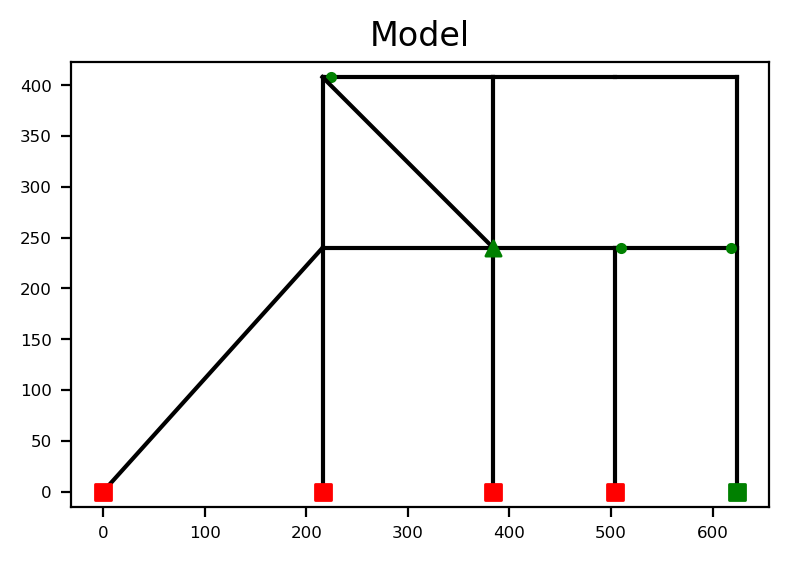

In [1757]:
DrawModel()

In [1758]:
# DISTRIBUTED GRAVITY LOADS
# DistributedGravityLoads are additive, they applied in the downward vertical direction
# not all floors need to be defined, but all bays within a floor must be defined (assign zero for no load)
#DistributedGravityLoad[Floor] = [Bay1DistributedLoad,Bay2DistributedLoad,...,BayNbayDistributedLoad]
DL1 = 5*kip/ft
DL2 = 3*kip/ft
DistributedGravityLoad[1] = [0,DL1,DL1,DL2]# by Floor, by Bay
DistributedGravityLoad[2] = [0,0,DL2,0]


In [1759]:
# NODAL LOADS
# NodalLoads are additive and are defined in global coordinates
# NodalLoad[Floor,ColumnLine,'FX,FY,MZ'] = NodalLoadValue
PL1 = 160*kip
PL2 = 280*kip
M1 = 1060*kip*ft
M2 = -280*kip*ft
NodalLoad[2,1,'FX'] = PL1 # Floor, ColumnLine
NodalLoad[1,4,'FY'] = PL2
NodalLoad[1,1,'MZ'] = M1
NodalLoad[2,2,'MZ'] = M2


In [1760]:
# DISPLAY SCALE FACTORS
# You may change the scale factor for the displays
# The value of 1.0 is applied to the program-computed optimal value
# When the user specifies a negative scale factor for the DeformedShape, 
#    the absolute value of the user input will be used a scale factor for the deformed shape

UserDisplayScaleFactor['Loads'] = 10.0
UserDisplayScaleFactor['DeformedShape'] = -100   # 
UserDisplayScaleFactor['BMD'] = 3.0
UserDisplayScaleFactor['SFD'] = 1.0
UserDisplayScaleFactor['AFD'] = 1.0
UserDisplayScaleFactor['DistributedLoad'] = 1.0
UserDisplayScaleFactor['NodalForce'] = 1.0
UserDisplayScaleFactor['NodalMoment'] = 1.0


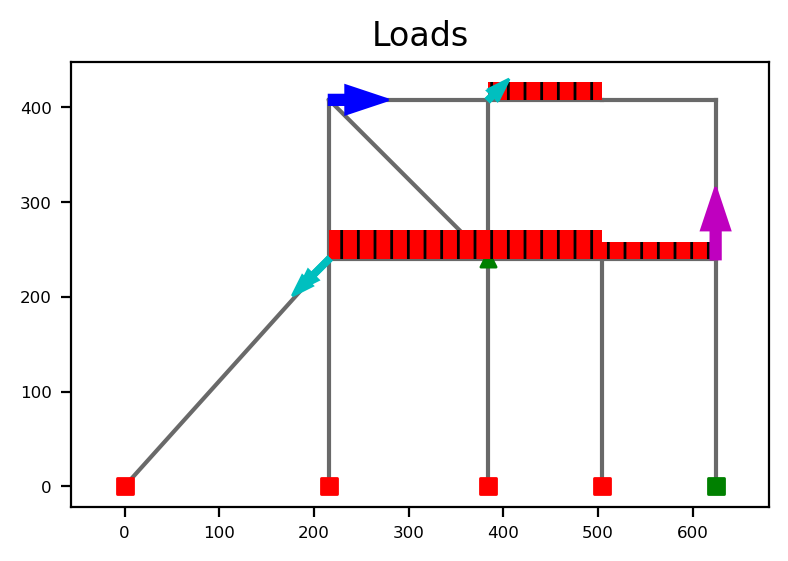

In [1761]:
DrawLoads()

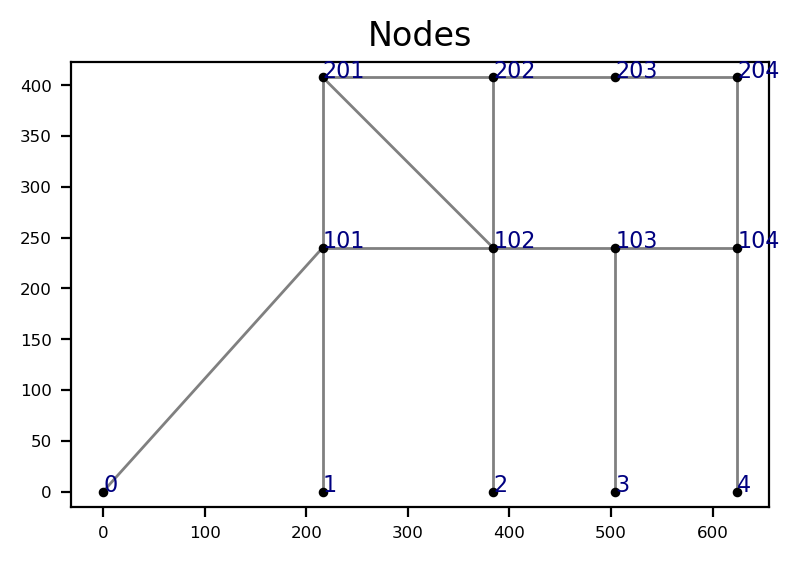

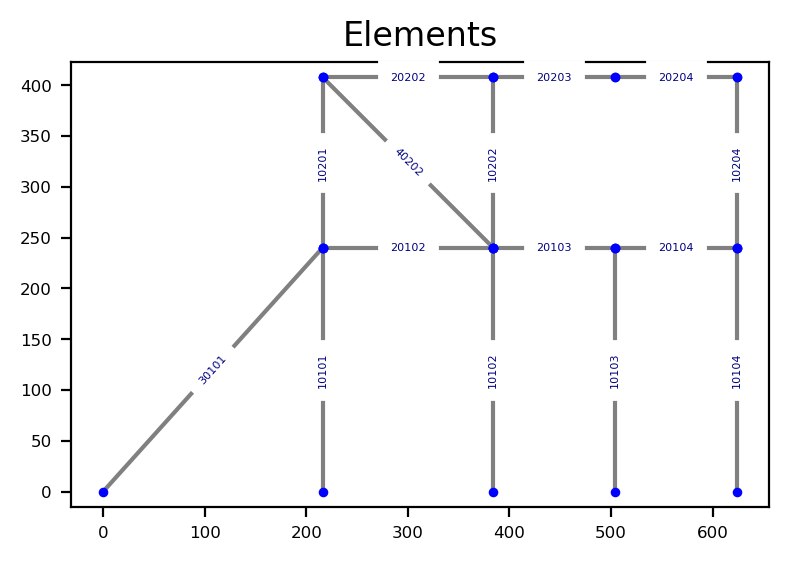

In [1762]:
DrawNodes()
DrawElements()

In [1763]:
# Analyze
RunStaticElasticFrameAnalysisInOpenSeesPy()

ANALYSIS COMPLETE!!


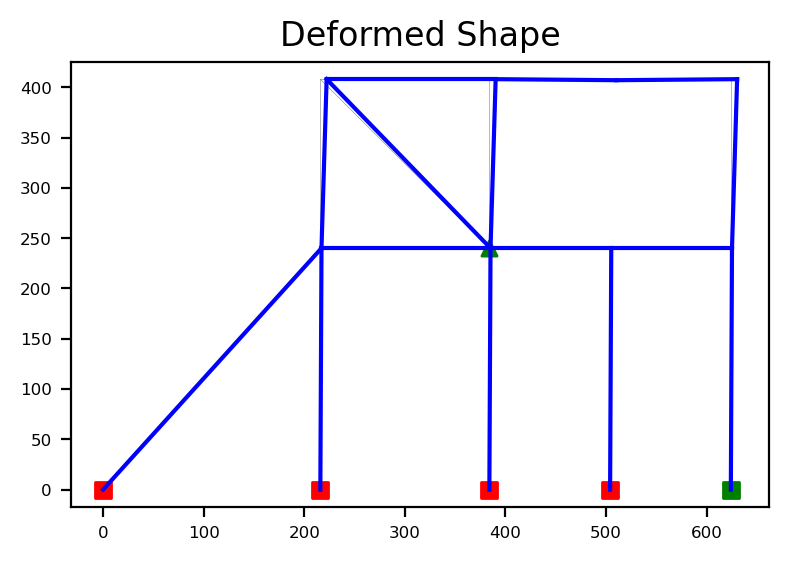

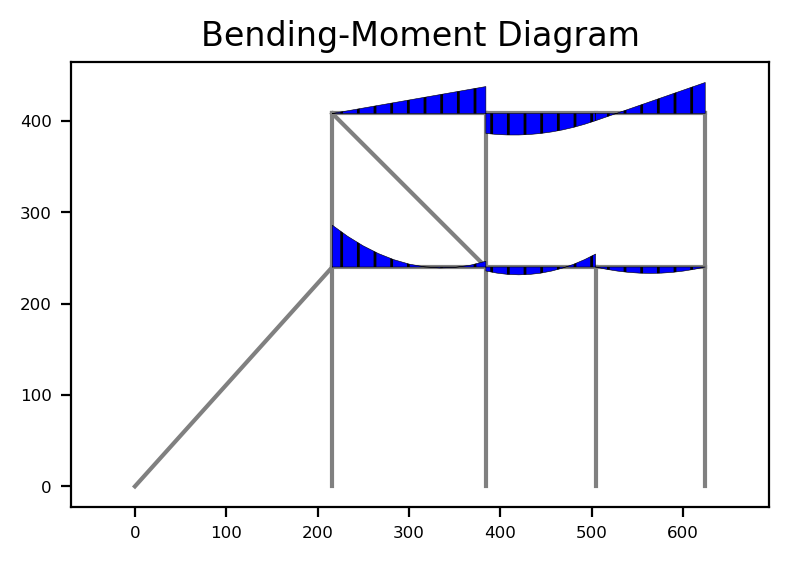

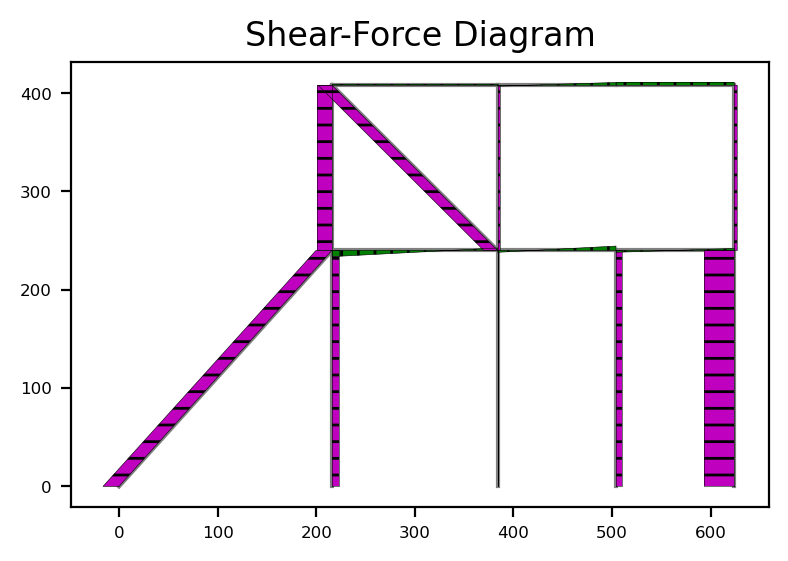

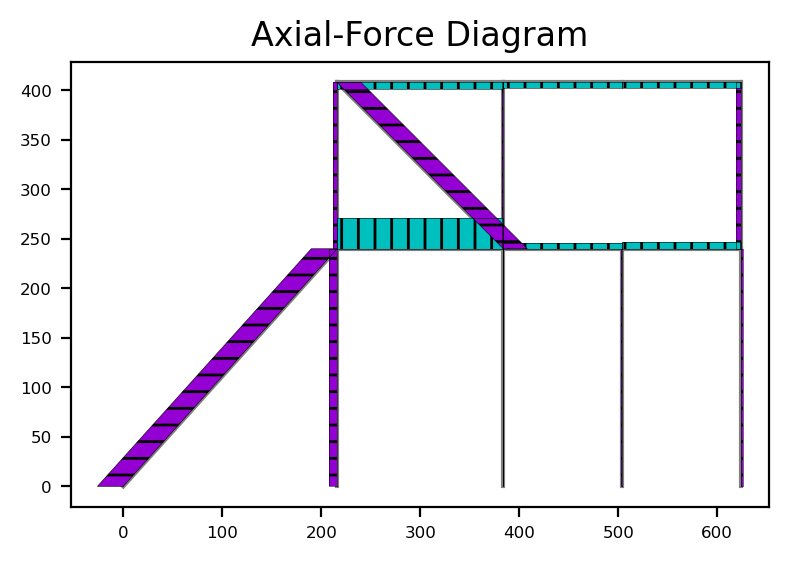

In [1764]:
DrawAnalysisResults()
SavePlotFigures()

In [1765]:
DisplayModelDataTables()

,NodeTag,Xcoord,Ycoord,NodeType,Floor,ColumnLine,NodeFixity,NodalLoad
0,0,0,0,Beam-Column Intersection,0,0,"{'dX': 1, 'dY': 1, 'rZ': 1}",NaN
1,1,216,0,Beam-Column Intersection,0,1,"{'dX': 1, 'dY': 1, 'rZ': 1}",NaN
2,2,384,0,Beam-Column Intersection,0,2,"{'dX': 1, 'dY': 1, 'rZ': 1}",NaN
3,3,504,0,Beam-Column Intersection,0,3,"{'dX': 1, 'dY': 1, 'rZ': 1}",NaN
4,4,624,0,Beam-Column Intersection,0,4,"{'dX': 1, 'dY': 1, 'rZ': 0}",NaN
101,101,216,240,Beam-Column Intersection,1,1,NaN,{'MZ': 12720}
102,102,384,240,Beam-Column Intersection,1,2,{'dY': 1},NaN
103,103,504,240,Beam-Column Intersection,1,3,NaN,NaN
104,104,624,240,Beam-Column Intersection,1,4,NaN,{'FY': 280}
201,201,216,408,Beam-Column Intersection,2,1,NaN,{'FX': 160}


,SectionType,A,E,Iz,SectionLabel
Column1,Elastic,1e+09,29000,27648,Column1
Column2,Elastic,1e+09,29000,8748,Column2
Beam1,Elastic,1e+09,29000,8748,Beam1
Beam2,Elastic,1e+09,29000,8748,Beam2
Diagonal1,Elastic,256,29000,5461.33,Diagonal1
Brace1,Elastic,36,29000,1e-06,Brace1


,ElementTag,StructuralElement,Story,ColumnLine,Floor,Bay,NodeI,NodeJ,SectionLabel,ElementLength,BeamMomentRelease,DistributedGravityLoad
10101,10101,Column,2,1,-999,-999,1,101,Column1,240,NaN,NaN
10102,10102,Column,2,2,-999,-999,2,102,Column1,240,NaN,NaN
10103,10103,Column,2,3,-999,-999,3,103,Column1,240,NaN,NaN
10104,10104,Column,2,4,-999,-999,4,104,Column1,240,NaN,NaN
10201,10201,Column,3,1,-999,-999,101,201,Column2,168,NaN,NaN
10202,10202,Column,3,2,-999,-999,102,202,Column2,168,NaN,NaN
10204,10204,Column,3,4,-999,-999,104,204,Column1,168,NaN,NaN
20102,20102,Beam,-999,-999,1,2,101,102,Beam1,168,0,0.416667
20103,20103,Beam,-999,-999,1,3,102,103,Beam1,120,0,0.416667
20104,20104,Beam,-999,-999,1,4,103,104,Beam1,120,NodeIJ,0.25


In [1766]:
DisplayOutputTables()

,dispX,dispY,rotZ
Maximum_Value,0.062429,2.007110e-09,0.000371
Maximum_Node,201.000000,1.040000e+02,101.000000
Minimum_Value,0.000000,-1.025241e-02,-0.000640
Minimum_Node,0.000000,2.030000e+02,201.000000
MaximumAbsolute_Value,0.062429,1.025241e-02,0.000640
MaximumAbsolute_Node,201.000000,2.030000e+02,201.000000


,Px_NodeI,Vy_NodeI,Mz_NodeI,Px_NodeJ,Vy_NodeJ,Mz_NodeJ
Maximum_Value,111.927277,55.624520,3436.865639,141.834944,242.525834,5914.489672
Maximum_Element,40202.000000,10101.000000,10101.000000,20102.000000,10104.000000,10101.000000
Minimum_Value,-141.834944,-242.525834,-1408.143710,-111.927277,-55.624520,-2185.656031
Minimum_Element,20102.000000,10104.000000,20203.000000,40202.000000,10101.000000,20204.000000
MaximumAbsolute_Value,141.834944,242.525834,3436.865639,141.834944,242.525834,5914.489672
MaximumAbsolute_Element,20102.000000,10104.000000,10101.000000,20102.000000,10104.000000,10101.000000


,dispX,dispY,rotZ
0,0.000000,0.000000e+00,0.000000
1,0.000000,0.000000e+00,0.000000
2,0.000000,0.000000e+00,0.000000
3,0.000000,0.000000e+00,0.000000
4,0.000000,0.000000e+00,0.000050
101,0.011485,-4.603409e-10,0.000371
102,0.011485,0.000000e+00,-0.000090
103,0.011485,-4.132575e-10,-0.000004
104,0.011485,2.007110e-09,-0.000243
201,0.062429,2.534751e-10,-0.000640


,Px_NodeI,Vy_NodeI,Mz_NodeI,Px_NodeJ,Vy_NodeJ,Mz_NodeJ
10101,-38.963980,55.624520,3.436866e+03,38.963980,-55.624520,5.914490e+03
10102,-0.437134,0.000000,3.547179e+02,0.437134,0.000000,-2.498058e+02
10103,-7.700125,49.935286,9.357572e+02,7.700125,-49.935286,9.122727e+02
10104,8.148306,-242.525834,0.000000e+00,-8.148306,242.525834,-1.955593e+03
10201,-18.176103,-123.218226,3.053585e+03,18.176103,123.218226,2.236502e-07
10202,-5.246325,18.816784,9.363595e+02,5.246325,-18.816784,-5.497677e+01
10204,-24.650295,22.474166,1.955593e+03,24.650295,-22.474166,2.185656e+03
20102,-141.834944,50.118894,2.946566e+03,141.834944,19.881106,-4.065921e+02
20103,-25.098477,15.064714,-2.799616e+02,25.098477,34.935286,-9.122727e+02
20104,-32.798601,15.000000,0.000000e+00,32.798601,15.000000,0.000000e+00


### Questions?
#### Contact Silvia Mazzoni: silviamazzoni@yahoo.com


## copyright: 
##   NO PART OF THIS CODE MAY BE REPRODUCED OR DISTRIBUTED WITHOUT PRIOR WRITTEN CONSENT FROM THE AUTHOR